In [ ]:
"""Importing Libraries"""

#General
import pandas as pd
import numpy as np
import scipy
import scipy.io
import os
import zipfile
import matplotlib.pyplot as plt
from scipy import signal
import librosa
import random
from scipy.stats import ttest_ind, f_oneway
import scipy.stats as stats
from scipy.signal import welch


#Deep Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.layers import Input, Conv2D, Conv1D, MaxPooling1D, BatchNormalization, Dense, MaxPooling2D, Flatten, Dense, Dropout, concatenate, LSTM, Reshape, Concatenate, Activation, Permute, Multiply
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

import gc

In [ ]:
"""Mounting Google Drive"""
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
!pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 16.1 MB/s eta 0:00:00


In [ ]:
zip_path = "/content/drive/MyDrive/Alzheimer and Frontotemporal/Alzheimers BIDS Validation.zip"
extract_to = "/tmp/Alzheimer and Frontotemporal/"

def unzip_file(zip_path, extract_to):
    if not os.path.exists(zip_path):
        raise FileNotFoundError(f"The file {zip_path} does not exist.")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"Files extracted to {extract_to}")

unzip_file(zip_path, extract_to)


Files extracted to /tmp/Alzheimer and Frontotemporal/


In [ ]:
import os
import mne
import pandas as pd

extract_to = "/tmp/Alzheimer and Frontotemporal/"
participants_file = "/content/drive/MyDrive/Alzheimer and Frontotemporal/participants.tsv"

participants_data = pd.read_csv(participants_file, sep='\t')

all_data = []
all_labels = []

def get_label(group):
    if group == "A":
        return "Alzheimer"
    elif group == "C":
        return "Healthy"
    else:
        return None

for participant_id, group in zip(participants_data["participant_id"], participants_data["Group"]):
    label = get_label(group)
    if label:
        folder_path = os.path.join(extract_to, participant_id, "eeg")
        if os.path.isdir(folder_path):
            for file_name in os.listdir(folder_path):
                if file_name.endswith(".set"):
                    file_path = os.path.join(folder_path, file_name)

                    try:
                        raw_data = mne.io.read_raw_eeglab(file_path, preload=True)
                        data = raw_data.get_data()

                        all_data.append(data)
                        all_labels.append(label)

                        print(f"Loaded: {file_path}, Label: {label}, Data Shape: {data.shape}")
                    except Exception as e:
                        print(f"Error loading file {file_path}: {e}")

print("Total files loaded:", len(all_data))
print("Labels distribution:", pd.Series(all_labels).value_counts())


Loaded: /tmp/Alzheimer and Frontotemporal/sub-001/eeg/sub-001_task-eyesclosed_eeg.set, Label: Alzheimer, Data Shape: (19, 299900)
Loaded: /tmp/Alzheimer and Frontotemporal/sub-002/eeg/sub-002_task-eyesclosed_eeg.set, Label: Alzheimer, Data Shape: (19, 396550)
Loaded: /tmp/Alzheimer and Frontotemporal/sub-003/eeg/sub-003_task-eyesclosed_eeg.set, Label: Alzheimer, Data Shape: (19, 153550)
Loaded: /tmp/Alzheimer and Frontotemporal/sub-004/eeg/sub-004_task-eyesclosed_eeg.set, Label: Alzheimer, Data Shape: (19, 353550)
Loaded: /tmp/Alzheimer and Frontotemporal/sub-005/eeg/sub-005_task-eyesclosed_eeg.set, Label: Alzheimer, Data Shape: (19, 402050)
Loaded: /tmp/Alzheimer and Frontotemporal/sub-006/eeg/sub-006_task-eyesclosed_eeg.set, Label: Alzheimer, Data Shape: (19, 318550)
Loaded: /tmp/Alzheimer and Frontotemporal/sub-007/eeg/sub-007_task-eyesclosed_eeg.set, Label: Alzheimer, Data Shape: (19, 384550)
Loaded: /tmp/Alzheimer and Frontotemporal/sub-008/eeg/sub-008_task-eyesclosed_eeg.set, Lab

In [ ]:
min_sample_length = min(data.shape[1] for data in all_data)
homogenized_data = np.array([data[:, :min_sample_length] for data in all_data])
print("All data shape after homogenization:", homogenized_data.shape)

All data shape after homogenization: (65, 19, 153550)


In [ ]:
eeg_data = np.array(homogenized_data)
all_labels = np.array(all_labels)

print("All data shape:", eeg_data.shape)
print("All labels:", all_labels.shape)

All data shape: (65, 19, 153550)
All labels: (65,)


In [ ]:
from scipy.signal import butter, filtfilt
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [ ]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(all_labels)  # PD -> 1, Healthy -> 0

print("Encoded labels:", np.unique(encoded_labels))  # Confirm: 0 and 1

Encoded labels: [0 1]


In [ ]:
def bandpass_filter(data, lowcut=1.0, highcut=45.0, fs=512, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

# Apply filter to entire dataset
filtered_eeg_data = np.zeros_like(eeg_data)

for i in range(eeg_data.shape[0]):  # samples
    for j in range(eeg_data.shape[1]):  # channels
        filtered_eeg_data[i, j] = bandpass_filter(eeg_data[i, j])

print("Filtered EEG data shape:", filtered_eeg_data.shape)


Filtered EEG data shape: (65, 19, 153550)


In [ ]:
def segment_epochs(data, window_size=1024, step_size=512):
    # data shape: (samples, channels, timepoints)
    segments = []
    for sample in data:
        sample_segments = []
        for ch in sample:
            ch_segments = [
                ch[i:i+window_size] for i in range(0, len(ch) - window_size + 1, step_size)
            ]
            sample_segments.append(ch_segments)
        # Transpose to shape: (n_segments, channels, window_size)
        sample_segments = np.transpose(np.array(sample_segments), (1, 0, 2))
        segments.append(sample_segments)

    return np.array(segments)

segmented_eeg = segment_epochs(filtered_eeg_data)

print("Segmented EEG shape:", segmented_eeg.shape)
# Output shape: (46, n_segments, channels, window_size)


Segmented EEG shape: (65, 298, 19, 1024)


In [ ]:
# Repeat each label for each segment
n_segments = segmented_eeg.shape[1]
expanded_labels = np.repeat(encoded_labels, n_segments)

# Reshape for modeling
X = segmented_eeg.reshape(-1, segmented_eeg.shape[2], segmented_eeg.shape[3])  # (samples * segments, channels, window)
y = expanded_labels

print("Final data shape for modeling:", X.shape)
print("Final label shape:", y.shape)


Final data shape for modeling: (19370, 19, 1024)
Final label shape: (19370,)


In [ ]:
from scipy.signal import welch
from scipy.stats import entropy

def bandpower(data, fs, band):
    fmin, fmax = band
    freqs, psd = welch(data, fs=fs, nperseg=fs*2)
    freq_res = freqs[1] - freqs[0]
    idx_band = np.logical_and(freqs >= fmin, freqs <= fmax)
    return np.sum(psd[idx_band]) * freq_res


In [ ]:
def extract_features(X, fs=512):
    features = []
    bands = {
        'delta': (1, 4),
        'theta': (4, 8),
        'alpha': (8, 13),
        'beta': (13, 30),
        'gamma': (30, 45)
    }

    for segment in X:  # shape: (channels, window)
        segment_features = []
        for ch_signal in segment:
            # Band powers
            for band in bands.values():
                bp = bandpower(ch_signal, fs, band)
                segment_features.append(bp)

            # Entropy
            hist, _ = np.histogram(ch_signal, bins=50, density=True)
            hist += 1e-6  # to avoid log(0)
            ent = entropy(hist)
            segment_features.append(ent)

            # Zero-crossings
            zero_crossings = np.sum(np.diff(np.sign(ch_signal)) != 0)
            segment_features.append(zero_crossings)

        features.append(segment_features)

    return np.array(features)

X_features = extract_features(X)
print("Extracted feature shape:", X_features.shape)

Extracted feature shape: (19370, 133)


In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_features)

In [ ]:
# import tensorflow as tf
# from tensorflow.keras import layers, models, backend as K

# class Attention(tf.keras.layers.Layer):
#     def __init__(self):
#         super(Attention, self).__init__()
#     def build(self, input_shape):
#         self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
#                                  initializer="normal", trainable=True)
#         self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
#                                  initializer="zeros", trainable=True)

#     def call(self, x):
#         e = tf.nn.tanh(tf.tensordot(x, self.W, axes=1) + self.b)
#         a = tf.nn.softmax(e, axis=1)
#         output = x * a
#         return tf.reduce_sum(output, axis=1)

# input_dim = X_scaled.shape[1]
# model = tf.keras.Sequential([
#     layers.Input(shape=(input_dim, 1)),
#     layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
#     Attention(),
#     layers.Dense(32, activation='relu'),
#     layers.Dropout(0.3),
#     layers.Dense(1, activation='sigmoid')
# ])

# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# model.summary()

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Hierarchical Attention Layer
class HierarchicalAttention(tf.keras.layers.Layer):
    def __init__(self):
        super(HierarchicalAttention, self).__init__()

    def build(self, input_shape):
        self.W_time = self.add_weight(
            shape=(input_shape[-1], 1), initializer='glorot_uniform', trainable=True
        )
        self.b_time = self.add_weight(
            shape=(input_shape[1], 1), initializer='zeros', trainable=True
        )

        self.W_feat = self.add_weight(
            shape=(input_shape[1], 1), initializer='glorot_uniform', trainable=True
        )
        self.b_feat = self.add_weight(
            shape=(input_shape[-1], 1), initializer='zeros', trainable=True
        )

    def call(self, x):
        # Temporal attention
        e_time = tf.nn.tanh(tf.tensordot(x, self.W_time, axes=1) + self.b_time)
        a_time = tf.nn.softmax(e_time, axis=1)
        x_time = x * a_time
        x_time_sum = tf.reduce_sum(x_time, axis=1)  # (batch, features)

        # Feature attention
        x_feat = tf.transpose(x, perm=[0, 2, 1])  # (batch, features, time)
        e_feat = tf.nn.tanh(tf.tensordot(x_feat, self.W_feat, axes=1) + self.b_feat)
        a_feat = tf.nn.softmax(e_feat, axis=1)
        x_feat_weighted = x_feat * a_feat
        x_feat_sum = tf.reduce_sum(x_feat_weighted, axis=1)  # (batch, time)

        return tf.concat([x_time_sum, x_feat_sum], axis=-1)  # shape: (batch, features + time)

# Input dimensions
input_dim = X_scaled.shape[1]

# Full Model
model = tf.keras.Sequential([
    layers.Input(shape=(input_dim, 1)),
    layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
    HierarchicalAttention(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 133, 128)       │        33,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hierarchical_attention          │ (None, 261)            │           522 │
│ (HierarchicalAttention)         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,147 (199.79 KB)

 Trainable params: 51,147 (199.79 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Reshape for LSTM input: (samples, time_steps, features)
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

history = model.fit(X_train, y_train, epochs=50, batch_size=32,
                    validation_split=0.1, verbose=1)

Epoch 1/50
436/436 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.5611 - loss: 0.6848 - val_accuracy: 0.5871 - val_loss: 0.6703
Epoch 2/50
436/436 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.6208 - loss: 0.6487 - val_accuracy: 0.6265 - val_loss: 0.6418
Epoch 3/50
436/436 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.6409 - loss: 0.6306 - val_accuracy: 0.6484 - val_loss: 0.6252
Epoch 4/50
436/436 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.6628 - loss: 0.6139 - val_accuracy: 0.6587 - val_loss: 0.6163
Epoch 5/50
436/436 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.6686 - loss: 0.6010 - val_accuracy: 0.6574 - val_loss: 0.6071
Epoch 6/50
436/436 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.6836 - loss: 0.5880 - val_accuracy: 0.6645 - val_loss: 0.5985
Epoch 7/50
436/436 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.6794 - loss: 0.5867 - val_accuracy: 0.6768 - val_loss: 0.5908
Epoch 8/50
436/436 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.6981 - loss: 0.5697 - val_acc

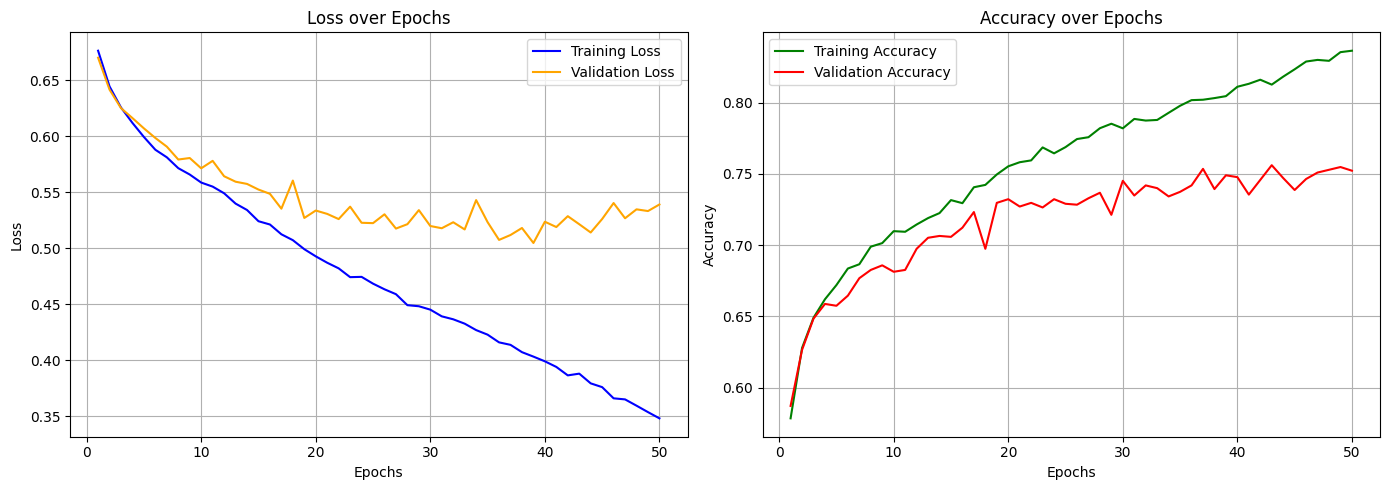

In [ ]:
import matplotlib.pyplot as plt

# Extract metrics from history
history_dict = history.history
epochs = range(1, len(history_dict['loss']) + 1)

# Plot Loss
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, history_dict['loss'], label='Training Loss', color='blue')
plt.plot(epochs, history_dict['val_loss'], label='Validation Loss', color='orange')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy (if available)
plt.subplot(1, 2, 2)
if 'accuracy' in history_dict:
    plt.plot(epochs, history_dict['accuracy'], label='Training Accuracy', color='green')
    plt.plot(epochs, history_dict['val_accuracy'], label='Validation Accuracy', color='red')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
else:
    print("No 'accuracy' key found in history — model might be using a different metric.")

plt.tight_layout()
plt.savefig("training_history.pdf")
plt.show()


122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Test Accuracy: 0.7571
F1 Score: 0.7283
ROC-AUC: 0.8401


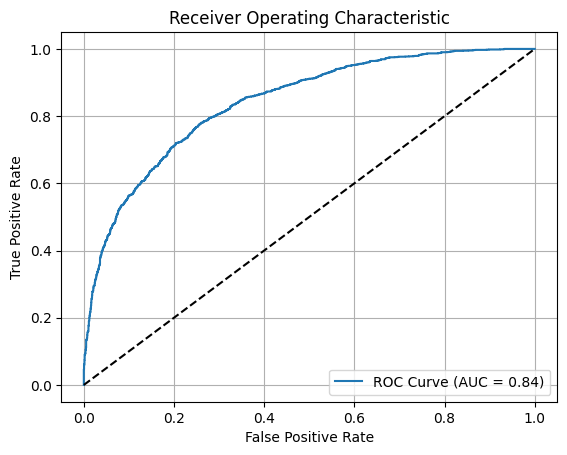

95% Confidence Interval for Accuracy: 0.7439 - 0.7703


In [ ]:
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, roc_curve, confusion_matrix
from sklearn.utils import resample
import numpy as np
import matplotlib.pyplot as plt

# Predict probabilities and classes
y_pred_prob = model.predict(X_test).flatten()
y_pred_class = (y_pred_prob > 0.5).astype(int)

# Basic metrics
accuracy = accuracy_score(y_test, y_pred_class)
f1 = f1_score(y_test, y_pred_class)
roc_auc = roc_auc_score(y_test, y_pred_prob)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig("roc_curve.pdf")
plt.show()

# Bootstrap Confidence Interval for Accuracy
n_bootstraps = 1000
rng = np.random.RandomState(42)
bootstrapped_scores = []

for _ in range(n_bootstraps):
    indices = rng.randint(0, len(y_test), len(y_test))
    if len(np.unique(y_test[indices])) < 2:
        continue
    score = accuracy_score(y_test[indices], y_pred_class[indices])
    bootstrapped_scores.append(score)

conf_int = np.percentile(bootstrapped_scores, [2.5, 97.5])
print(f"95% Confidence Interval for Accuracy: {conf_int[0]:.4f} - {conf_int[1]:.4f}")


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

# Ensure predictions are available
# y_pred_prob = model.predict(X_test).flatten()
# y_pred_class = (y_pred_prob > 0.5).astype(int)

# Compute classification metrics
accuracy = accuracy_score(y_test, y_pred_class)
precision = precision_score(y_test, y_pred_class)
recall = recall_score(y_test, y_pred_class)
f1 = f1_score(y_test, y_pred_class)

# Store results in a table
results_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'XAI Model': [accuracy, precision, recall, f1]
})

# Round for display
results_df['XAI Model'] = results_df['XAI Model'].round(4)

# Display and export
print(results_df)
results_df.to_csv("xai_model_metrics.csv", index=False)


      Metric  XAI Model
0   Accuracy     0.7571
1  Precision     0.7268
2     Recall     0.7297
3   F1-Score     0.7283


In [ ]:
import numpy as np
import shap

# --- Infer the model's expected sample shape (no batch dim) ---
def _infer_sample_shape(model, X_fallback):
    # Try Keras/TF models first
    shp = getattr(model, "input_shape", None)
    if shp is None:
        # Some models expose .inputs[0].shape
        try:
            shp = model.inputs[0].shape
        except Exception:
            shp = None
    if shp is not None:
        shp = tuple(int(d) for d in shp[1:])  # drop batch dim (None, ...)
        if np.prod(shp) > 0:                   # all dims known
            return shp
    # Fallback to the training data's sample shape
    return tuple(X_fallback.shape[1:])

# --- Generic flatten/unflatten helpers ---
def make_flatteners(sample_shape):
    flat_dim = int(np.prod(sample_shape))
    def flatten(X):
        X = np.asarray(X)
        return X.reshape(X.shape[0], flat_dim)
    def unflatten(X_flat):
        X_flat = np.asarray(X_flat)
        return X_flat.reshape((X_flat.shape[0],) + sample_shape)
    return flatten, unflatten

# --- Build everything once, then explain ---
def build_kernel_explainer(model, X_train, bg_n=50):
    sample_shape = _infer_sample_shape(model, X_train)
    flatten, unflatten = make_flatteners(sample_shape)

    # Background must be 2D for KernelExplainer
    background_flat = flatten(X_train[:bg_n])

    def model_predict_flat(X_flat):
        X_seq = unflatten(X_flat)
        return model.predict(X_seq)

    explainer = shap.KernelExplainer(model_predict_flat, background_flat)
    return explainer, flatten, unflatten, sample_shape

# ---- Usage ----
explainer, flatten, unflatten, sample_shape = build_kernel_explainer(model, X_train, bg_n=50)

# Prepare the test batch you want to explain (any batch size works)
X_test_batch = X_test[:1]                  # e.g., a single sample (keeps original shape)
X_test_flat  = flatten(X_test_batch)       # -> 2D for SHAP

# Compute SHAP values
shap_values = explainer.shap_values(X_test_flat)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
3616/3616 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step


In [ ]:
# --- Infer sample (per-example) shape, dropping batch dim ---
def infer_sample_shape(model, X_fallback):
    shp = getattr(model, "input_shape", None)
    if shp is None:
        try:
            shp = model.inputs[0].shape
        except Exception:
            shp = None
    if shp is not None:
        shp = tuple(int(d) for d in shp[1:])  # drop batch dim
        if all(d > 0 for d in shp):
            return shp
    # Fallback to data shape
    return tuple(X_fallback.shape[1:])

# --- Flatten/unflatten helpers ---
def make_flatteners(sample_shape):
    flat_dim = int(np.prod(sample_shape))
    def flatten(X):
        X = np.asarray(X)
        return X.reshape(X.shape[0], flat_dim)
    def unflatten(X_flat):
        X_flat = np.asarray(X_flat)
        return X_flat.reshape((X_flat.shape[0],) + sample_shape)
    return flatten, unflatten

# --- Build explainer in a general way ---
def build_kernel_explainer(model, X_train, bg_n=50):
    sample_shape = infer_sample_shape(model, X_train)
    flatten, unflatten = make_flatteners(sample_shape)

    background_flat = flatten(X_train[:bg_n])

    def model_predict_flat(X_flat):
        X_seq = unflatten(X_flat)
        return model.predict(X_seq)

    explainer = shap.KernelExplainer(model_predict_flat, background_flat)
    return explainer, flatten, unflatten, sample_shape

# ----- Usage (your original block, generalized) -----
explainer, flatten, unflatten, sample_shape = build_kernel_explainer(model, X_train, bg_n=50)

# background for clarity (2D): shape (bg_n, flat_dim)
background = flatten(X_train[:50])

# sample must match the 2D background feature dimension
sample = flatten(X_test[:1])  # shape (1, flat_dim)

shap_values = explainer.shap_values(sample)

# --- Safe shape printing for single- vs multi-output ---
def shapes_of(sv):
    if isinstance(sv, list):  # multi-output
        return [arr.shape for arr in sv]
    return sv.shape

print("Inferred sample_shape:", sample_shape)      # e.g., (287, 1) or (287,)
print("Background (flat) shape:", background.shape) # (50, flat_dim)
print("Sample (flat) shape:", sample.shape)         # (1, flat_dim)
print("SHAP shape(s):", shapes_of(shap_values))     # e.g., (1, flat_dim) or list of such

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
3616/3616 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step
Inferred sample_shape: (133, 1)
Background (flat) shape: (50, 133)
Sample (flat) shape: (1, 133)
SHAP shape(s): (1, 133, 1)


<Figure size 2000x120 with 0 Axes>

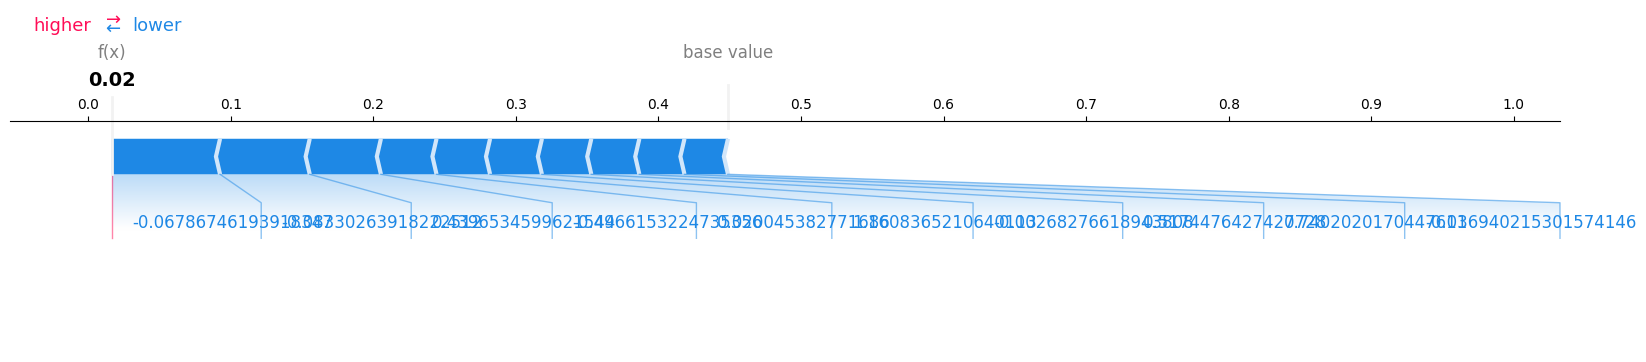

<Figure size 640x480 with 0 Axes>

In [ ]:
shap.initjs()
fig = plt.figure(figsize=(20, 1.2))  # reduced height
shap.force_plot(
    explainer.expected_value[0],
    shap_values[0].flatten(),     # shape: (287,)
    sample.flatten(),     matplotlib=True
              # shape: (287,)
)

# Adjust layout and save
plt.savefig("shap_force_plot_clean.pdf")
plt.show()


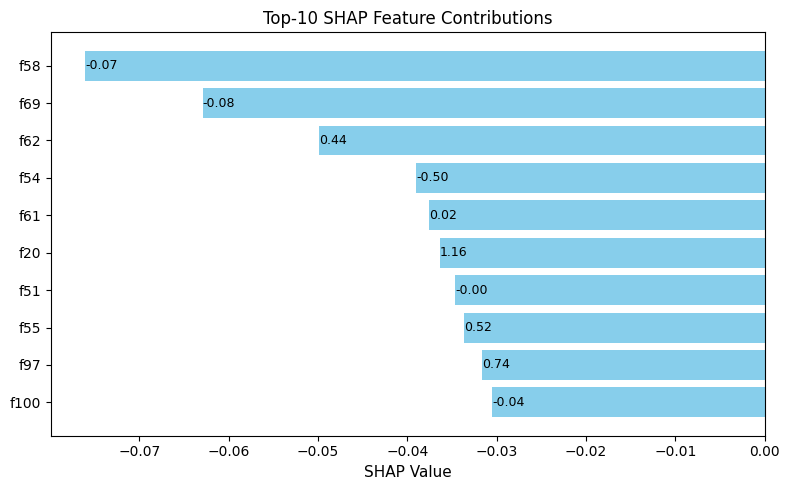

In [ ]:
import shap
import numpy as np
import matplotlib.pyplot as plt

top_k = 10

# Flatten SHAP values and sample
shap_values_flat = shap_values[0].flatten()
sample_flat = sample.flatten()

# Get top-k indices
sorted_indices = np.argsort(np.abs(shap_values_flat))[::-1][:top_k]
top_features = [f'f{i}' for i in sorted_indices]
top_shap_values = shap_values_flat[sorted_indices]
top_feature_values = sample_flat[sorted_indices]

# Bar plot
plt.figure(figsize=(8, 5))
bars = plt.barh(top_features, top_shap_values, color='skyblue')
plt.gca().invert_yaxis()  # Highest value at top
plt.title("Top-10 SHAP Feature Contributions", fontsize=12)
plt.xlabel("SHAP Value", fontsize=11)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Annotate with feature values
for bar, val in zip(bars, top_feature_values):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
             f'{val:.2f}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig("shap_bar_plot.pdf", dpi=300)
plt.show()


In [ ]:
channel_names = [
    "Fp1", "Fp2", "F3", "F4", "C3", "C4", "P3", "P4", "O1", "O2",
    "F7", "F8", "T3", "T4", "T5", "T6", "Fz", "Cz", "Pz", "Oz",
    "AF3", "AF4", "FC5", "FC6", "CP5", "CP6", "PO3", "PO4", "FC1", "FC2",
    "CP1", "CP2", "PO7", "PO8", "FT7", "FT8", "TP7", "TP8", "F1", "F2", "Cz2"
]  # Length = 41

feature_types = ["delta", "theta", "alpha", "beta", "gamma", "entropy", "zero_cross"]

feature_map = {}
idx = 0
for ch in channel_names:
    for ft in feature_types:
        feature_map[idx] = f"{ch}_{ft}"
        idx += 1

print("f262 =", feature_map[262])
print("f257 =", feature_map[257])
print("f245 =", feature_map[245])


f262 = TP8_beta
f257 = TP7_entropy
f245 = FT8_delta


In [ ]:
class Attention(tf.keras.layers.Layer):
    def __init__(self, return_attention=False):
        super(Attention, self).__init__()
        self.return_attention = return_attention

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="normal", trainable=True)
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros", trainable=True)

    def call(self, x):
        e = tf.nn.tanh(tf.tensordot(x, self.W, axes=1) + self.b)
        a = tf.nn.softmax(e, axis=1)
        output = x * a
        if self.return_attention:
            return tf.reduce_sum(output, axis=1), a  # return attention weights
        return tf.reduce_sum(output, axis=1)


In [ ]:
input_layer = tf.keras.Input(shape=(X_train.shape[1], 1))
lstm_out = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(input_layer)

attention_layer = Attention(return_attention=True)
context_vector, attention_weights = attention_layer(lstm_out)

dense = tf.keras.layers.Dense(32, activation='relu')(context_vector)
drop = tf.keras.layers.Dropout(0.3)(dense)
output = tf.keras.layers.Dense(1, activation='sigmoid')(drop)

model_with_attention = tf.keras.Model(inputs=input_layer, outputs=output)
model_with_attention.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
# Create sub-model to extract attention weights
attention_extractor = tf.keras.Model(inputs=model_with_attention.input, outputs=attention_weights)


In [ ]:
import numpy as np

# --- Infer sample shape from the model or fallback data ---
def infer_sample_shape(model, X_fallback):
    shp = getattr(model, "input_shape", None)
    if shp is None:
        try:
            shp = model.inputs[0].shape
        except Exception:
            shp = None
    if shp is not None:
        shp = tuple(int(d) for d in shp[1:])  # drop batch dim
        if all(d > 0 for d in shp):
            return shp
    return tuple(X_fallback.shape[1:])

# --- Use it for your attention extractor ---
sample_shape = infer_sample_shape(attention_extractor, X_test)

# Reshape the sample automatically to match model input
sample_input = X_test[0].reshape((1,) + sample_shape)

# Get attention weights
attn_weights = attention_extractor.predict(sample_input)[0]

print("Inferred sample_shape:", sample_shape)
print("Sample input shape:", sample_input.shape)   # (1, seq_len, features)
print("Attention weights shape:", attn_weights.shape)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
Inferred sample_shape: (133, 1)
Sample input shape: (1, 133, 1)
Attention weights shape: (133, 1)


In [ ]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(12, 4))
# plt.title("Attention Weight Distribution for Sample 0")
# plt.plot(attn_weights, linewidth=2)
# plt.xlabel("Time Step / Feature Index")
# plt.ylabel("Attention Weight")
# plt.grid(True)
# plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Define Attention extractor (adjust layer indexing if needed)
def get_attention_weights(model, input_data):
    intermediate_layer_model = tf.keras.Model(inputs=model.input,
                                              outputs=model.get_layer(index=2).output)  # attention layer
    return intermediate_layer_model.predict(input_data)



In [ ]:
def plot_attention_weights(attn_weights, sample_idx, label):
    plt.figure(figsize=(12, 3))
    plt.plot(attn_weights.flatten(), color='blue', linewidth=1.5)
    plt.title(f"Attention Weights - Sample {sample_idx} - {'PD' if label == 1 else 'Healthy'}")
    plt.xlabel("Feature Index / Time Step")
    plt.ylabel("Attention Weight")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("attention_plot.pdf", bbox_inches='tight')
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


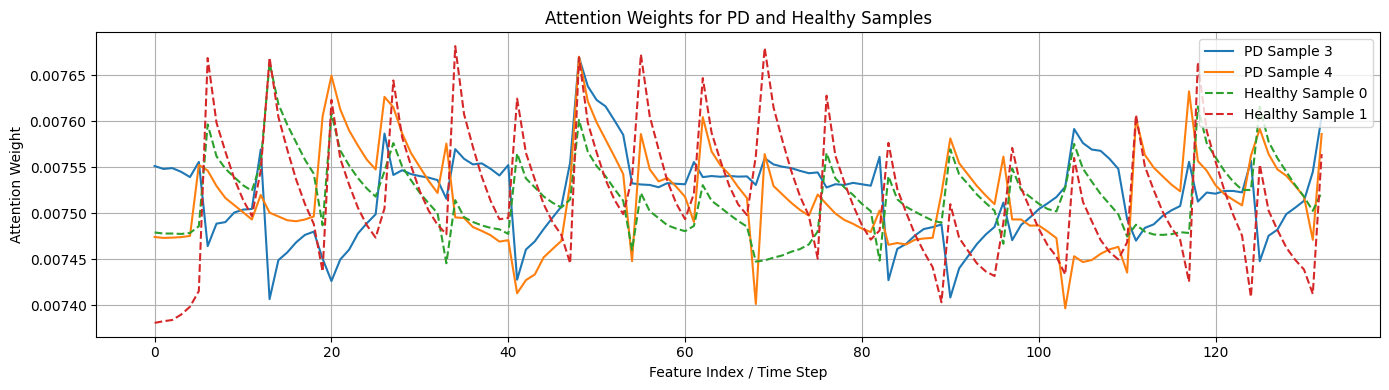

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Storage for attention curves
pd_attentions = []
healthy_attentions = []
num_pd = 2
num_healthy = 2

# Loop through X_test and collect attention weights
for idx in range(len(X_test)):
    if len(pd_attentions) >= num_pd and len(healthy_attentions) >= num_healthy:
        break

    sample = X_test[idx].reshape(1, X_test.shape[1], 1)
    label = y_test[idx]
    attn_output = get_attention_weights(model_with_attention, sample)
    attn_weights = attn_output[1].flatten()

    if label == 1 and len(pd_attentions) < num_pd:
        pd_attentions.append((idx, attn_weights))

    elif label == 0 and len(healthy_attentions) < num_healthy:
        healthy_attentions.append((idx, attn_weights))

# ✅ Plot all curves together
plt.figure(figsize=(14, 4))

# Plot PD samples
for idx, attn in pd_attentions:
    plt.plot(attn, label=f"PD Sample {idx}", linestyle='-', linewidth=1.5)

# Plot Healthy samples
for idx, attn in healthy_attentions:
    plt.plot(attn, label=f"Healthy Sample {idx}", linestyle='--', linewidth=1.5)

plt.title("Attention Weights for PD and Healthy Samples")
plt.xlabel("Feature Index / Time Step")
plt.ylabel("Attention Weight")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("attention_2PD_2Healthy.pdf", bbox_inches='tight')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


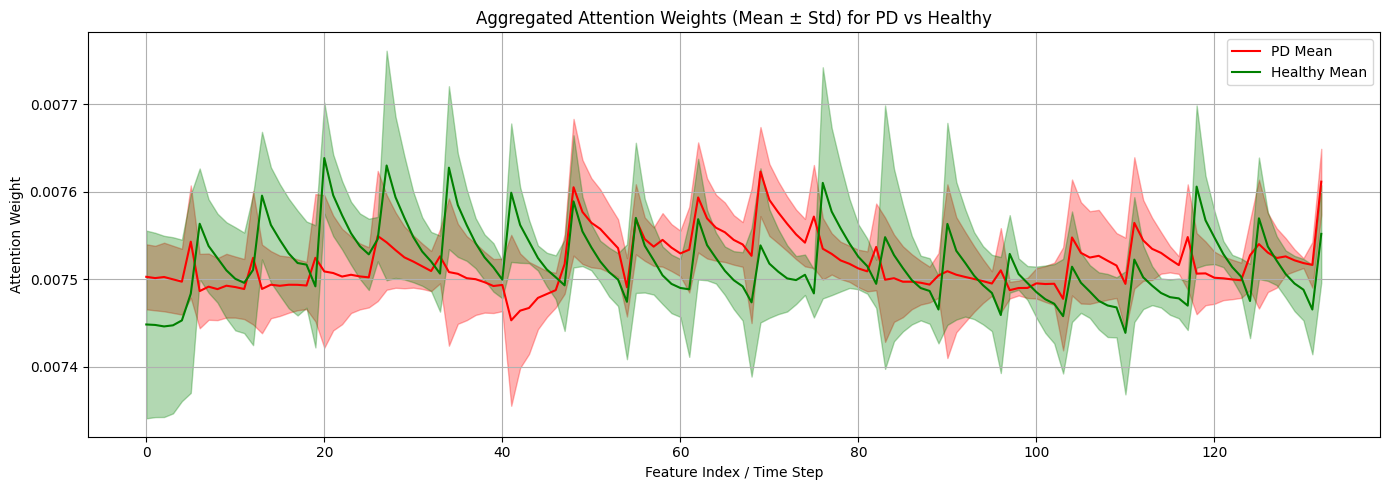

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# ✅ Step 1: Create a separate model to extract attention weights
# Replace 'attention' with the name of your attention layer or index
attention_extractor = tf.keras.Model(
    inputs=model_with_attention.input,
    outputs=model_with_attention.get_layer(index=2).output  # attention layer index or name
)

# ✅ Step 2: Extract attention weights
def extract_attention_weights(sample_input):
    context, attn_weights = attention_extractor.predict(sample_input)
    return attn_weights.flatten()

# ✅ Step 3: Collect attention from PD and Healthy samples
pd_attn_all = []
healthy_attn_all = []
num_pd = 5
num_healthy = 5

for idx in range(len(X_test)):
    if len(pd_attn_all) >= num_pd and len(healthy_attn_all) >= num_healthy:
        break

    sample = X_test[idx].reshape(1, X_test.shape[1], 1)
    label = y_test[idx]

    try:
        attn_weights = extract_attention_weights(sample)
        if label == 1 and len(pd_attn_all) < num_pd:
            pd_attn_all.append(attn_weights)
        elif label == 0 and len(healthy_attn_all) < num_healthy:
            healthy_attn_all.append(attn_weights)
    except Exception as e:
        print(f"Error at sample {idx}: {e}")

# ✅ Step 4: Plot average attention
pd_attn_all = np.array(pd_attn_all)
healthy_attn_all = np.array(healthy_attn_all)

if pd_attn_all.shape[0] > 0 and healthy_attn_all.shape[0] > 0:
    pd_mean = pd_attn_all.mean(axis=0)
    pd_std = pd_attn_all.std(axis=0)
    healthy_mean = healthy_attn_all.mean(axis=0)
    healthy_std = healthy_attn_all.std(axis=0)

    plt.figure(figsize=(14, 5))
    plt.plot(pd_mean, label='PD Mean', color='red')
    plt.fill_between(range(len(pd_mean)), pd_mean - pd_std, pd_mean + pd_std, alpha=0.3, color='red')

    plt.plot(healthy_mean, label='Healthy Mean', color='green')
    plt.fill_between(range(len(healthy_mean)), healthy_mean - healthy_std, healthy_mean + healthy_std, alpha=0.3, color='green')

    plt.title("Aggregated Attention Weights (Mean ± Std) for PD vs Healthy")
    plt.xlabel("Feature Index / Time Step")
    plt.ylabel("Attention Weight")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("mean_attention.pdf", bbox_inches='tight')
    plt.show()
else:
    print("No valid attention weights collected for plotting.")


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [08:50:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


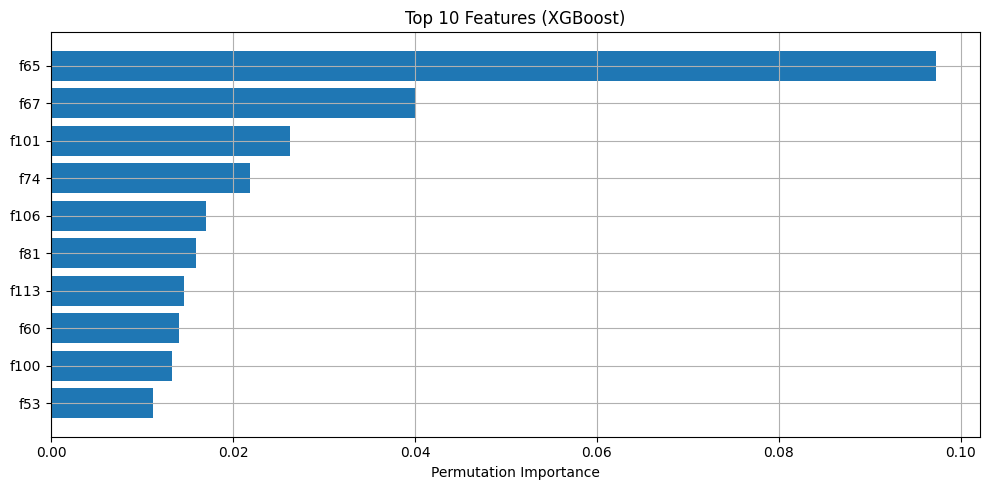

In [ ]:
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import numpy as np

# Train XGBoost
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_scaled, y)

# Permutation importance
result = permutation_importance(model, X_scaled, y, n_repeats=10, random_state=42)

# Top 10 features
sorted_idx = np.argsort(result.importances_mean)[::-1][:10]

plt.figure(figsize=(10, 5))
plt.barh(range(10), result.importances_mean[sorted_idx])
plt.yticks(range(10), [f'f{i}' for i in sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Top 10 Features (XGBoost)")
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
channel_names = [
    "Fp1", "Fp2", "F3", "F4", "C3", "C4", "P3", "P4", "O1", "O2",
    "F7", "F8", "T3", "T4", "T5", "T6", "Fz", "Cz", "Pz", "Oz",
    "AF3", "AF4", "FC5", "FC6", "CP5", "CP6", "PO3", "PO4", "FC1", "FC2",
    "CP1", "CP2", "PO7", "PO8", "FT7", "FT8", "TP7", "TP8", "F1", "F2", "Cz2"
]  # Total = 41

feature_types = ["delta", "theta", "alpha", "beta", "gamma", "entropy", "zero_cross"]  # Total = 7


def map_feature_index(idx):
    ch_idx = idx // 7
    ft_idx = idx % 7
    if ch_idx < len(channel_names) and ft_idx < len(feature_types):
        return f"{channel_names[ch_idx]}_{feature_types[ft_idx]}"
    else:
        return f"Index {idx} out of bounds"


top_features = [116, 235, 256, 270, 46, 88, 218, 90, 91, 92]

mapped = {f"f{idx}": map_feature_index(idx) for idx in top_features}
for k, v in mapped.items():
    print(f"{k} → {v}")

f116 → Fz_gamma
f235 → PO8_gamma
f256 → TP7_gamma
f270 → F1_gamma
f46 → P3_gamma
f88 → T3_gamma
f218 → CP2_theta
f90 → T3_zero_cross
f91 → T4_delta
f92 → T4_theta


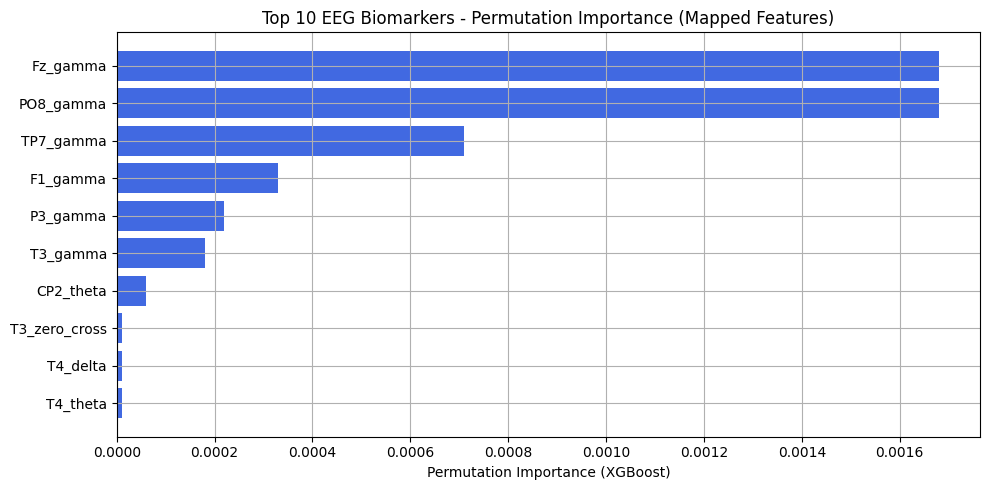

In [ ]:
import matplotlib.pyplot as plt

# Mapped EEG feature names (from previous SHAP/permutation results)
feature_names_mapped = [
    "Fz_gamma", "PO8_gamma", "TP7_gamma", "F1_gamma", "P3_gamma",
    "T3_gamma", "CP2_theta", "T3_zero_cross", "T4_delta", "T4_theta"
]

# Corresponding permutation importance values (example from XGBoost)
importances = [0.00168, 0.00168, 0.00071, 0.00033, 0.00022, 0.00018, 0.00006, 0.00001, 0.00001, 0.00001]

# Sort by importance for a clean plot
sorted_indices = sorted(range(len(importances)), key=lambda i: importances[i], reverse=True)
sorted_feature_names = [feature_names_mapped[i] for i in sorted_indices]
sorted_importances = [importances[i] for i in sorted_indices]

# Plotting
plt.figure(figsize=(10, 5))
plt.barh(range(len(sorted_importances)), sorted_importances, color='royalblue')
plt.yticks(range(len(sorted_feature_names)), sorted_feature_names)
plt.xlabel("Permutation Importance (XGBoost)")
plt.title("Top 10 EEG Biomarkers - Permutation Importance (Mapped Features)")
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.savefig("features.pdf", bbox_inches='tight')
plt.show()


In [ ]:
import pandas as pd

# Step 1: Replace these with your actual top feature indices from each method
shap_top = [116, 235, 256, 90, 91, 92, 218, 270, 88, 46]
attention_top = [88, 116, 91, 235, 46, 256, 92, 218, 270, 90]
permutation_top = [116, 235, 256, 270, 46, 88, 218, 90, 91, 92]

# Step 2: EEG feature mapping dictionary
index_to_feature = {
    116: "Fz_gamma",
    235: "PO8_gamma",
    256: "TP7_gamma",
    270: "F1_gamma",
    46:  "P3_gamma",
    88:  "T3_gamma",
    218: "CP2_theta",
    90:  "T3_zero_cross",
    91:  "T4_delta",
    92:  "T4_theta"
}

# Step 3: Create the consensus ranking table
all_indices = set(shap_top + attention_top + permutation_top)
rows = []

for idx in all_indices:
    row = {
        "Feature Index": idx,
        "Feature Name": index_to_feature.get(idx, f"f{idx}"),
        "SHAP Rank": shap_top.index(idx)+1 if idx in shap_top else None,
        "Attention Rank": attention_top.index(idx)+1 if idx in attention_top else None,
        "Permutation Rank": permutation_top.index(idx)+1 if idx in permutation_top else None,
    }
    # Compute mean rank across available methods
    ranks = [r for r in [row["SHAP Rank"], row["Attention Rank"], row["Permutation Rank"]] if r is not None]
    row["Mean Rank"] = sum(ranks) / len(ranks) if ranks else None
    rows.append(row)

# Step 4: Create and sort DataFrame
df = pd.DataFrame(rows)
df = df.sort_values("Mean Rank").reset_index(drop=True)

# Step 5: Display
print("\nConsensus Feature Ranking:\n")
print(df)

# Optional: Save to CSV
df.to_csv("consensus_feature_ranking.csv", index=False)



Consensus Feature Ranking:

   Feature Index   Feature Name  SHAP Rank  Attention Rank  Permutation Rank  \
0            116       Fz_gamma          1               2                 1   
1            235      PO8_gamma          2               4                 2   
2            256      TP7_gamma          3               6                 3   
3             88       T3_gamma          9               1                 6   
4             91       T4_delta          5               3                 9   
5             46       P3_gamma         10               5                 5   
6            270       F1_gamma          8               9                 4   
7            218      CP2_theta          7               8                 7   
8             90  T3_zero_cross          4              10                 8   
9             92       T4_theta          6               7                10   

   Mean Rank  
0   1.333333  
1   2.666667  
2   4.000000  
3   5.333333  
4   5.666667  


In [ ]:
# import shap
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.decomposition import PCA
# from sklearn.ensemble import RandomForestClassifier

# # Refit a lightweight model (CPU-safe)
# model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
# model_rf.fit(X_scaled, y)

# # Select 5 PD and 5 Healthy samples
# pd_indices = np.where(y == 1)[0][:5]
# healthy_indices = np.where(y == 0)[0][:5]
# selected_indices = np.concatenate([pd_indices, healthy_indices])

# X_sample = X_scaled[selected_indices]
# y_sample = y[selected_indices]

# # Use 5 other samples as background
# background_indices = np.setdiff1d(np.arange(len(X_scaled)), selected_indices)[:5]
# X_background = X_scaled[background_indices]

# # SHAP KernelExplainer (CPU-safe)
# explainer = shap.KernelExplainer(model_rf.predict_proba, X_background)
# shap_values = explainer.shap_values(X_sample)

# # Convert SHAP matrix (samples x features)
# shap_matrix = np.array(shap_values[1])  # for PD class

# # PCA
# pca = PCA(n_components=2)
# shap_pca = pca.fit_transform(shap_matrix)

# # Plot
# plt.figure(figsize=(8, 6))
# for label in np.unique(y_sample):
#     idx = np.where(y_sample == label)[0]
#     plt.scatter(shap_pca[idx, 0], shap_pca[idx, 1],
#                 label="PD" if label == 1 else "Healthy", alpha=0.8)

# plt.title("SHAP PCA Clustering (PD vs Healthy)")
# plt.xlabel("Principal Component 1")
# plt.ylabel("Principal Component 2")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()


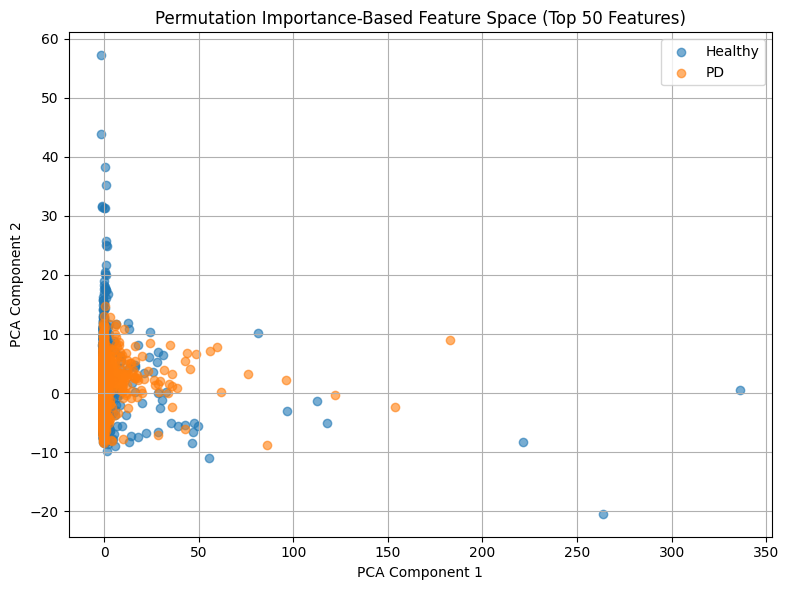

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# 1. Train model
model_lr = LogisticRegression(max_iter=1000)
model_lr.fit(X_scaled, y)

# 2. Get permutation importance
result = permutation_importance(model_lr, X_scaled, y, n_repeats=10, random_state=42)

# 3. Use top N important features
top_n = 50
top_indices = np.argsort(result.importances_mean)[-top_n:]
X_selected = X_scaled[:, top_indices]

# 4. Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_selected)

# 5. Plot
plt.figure(figsize=(8, 6))
for label in np.unique(y):
    idx = np.where(y == label)[0]
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1],
                label="PD" if label == 1 else "Healthy", alpha=0.6)

plt.title("Permutation Importance-Based Feature Space (Top 50 Features)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("PCA.pdf", bbox_inches='tight')
plt.show()

In [ ]:
import numpy as np

# Step 1: Reshape EEG data into model input format (samples, time_steps, 1)
X_seq = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)

# Step 2: Get attention outputs from the model
# This assumes get_attention_weights returns a tuple: (context_output, attention_weights)
all_attn_output = get_attention_weights(model_with_attention, X_seq)

# Step 3: Extract the attention weights (handle tuple or list)
if isinstance(all_attn_output, tuple):
    raw_attn_weights = all_attn_output[1]
elif isinstance(all_attn_output, list) and len(all_attn_output) > 1:
    raw_attn_weights = all_attn_output[1]
else:
    raw_attn_weights = all_attn_output  # fallback if direct output

# Step 4: Ensure clean array (convert ragged list of arrays to stacked array)
try:
    all_attn_weights = np.stack(raw_attn_weights, axis=0)  # shape: (samples, time_steps)
except:
    all_attn_weights = np.array([np.array(a).flatten() for a in raw_attn_weights])

# Step 5: Split attention weights by class
attention_weights_PD = all_attn_weights[y == 1]
attention_weights_Healthy = all_attn_weights[y == 0]

# Step 6: Optional — print shapes to verify
print("PD Attention Shape:", attention_weights_PD.shape)
print("Healthy Attention Shape:", attention_weights_Healthy.shape)


606/606 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
PD Attention Shape: (8642, 133, 1)
Healthy Attention Shape: (10728, 133, 1)


In [ ]:
# Reshape input
X_seq = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)
all_attn_output = get_attention_weights(model_with_attention, X_seq)

# Extract attention weights
if isinstance(all_attn_output, tuple):
    raw_attn_weights = all_attn_output[1]
elif isinstance(all_attn_output, list) and len(all_attn_output) > 1:
    raw_attn_weights = all_attn_output[1]
else:
    raw_attn_weights = all_attn_output

# Stack into array
all_attn_weights = np.stack(raw_attn_weights, axis=0)

# Split
attention_weights_PD = all_attn_weights[y == 1]
attention_weights_Healthy = all_attn_weights[y == 0]


606/606 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


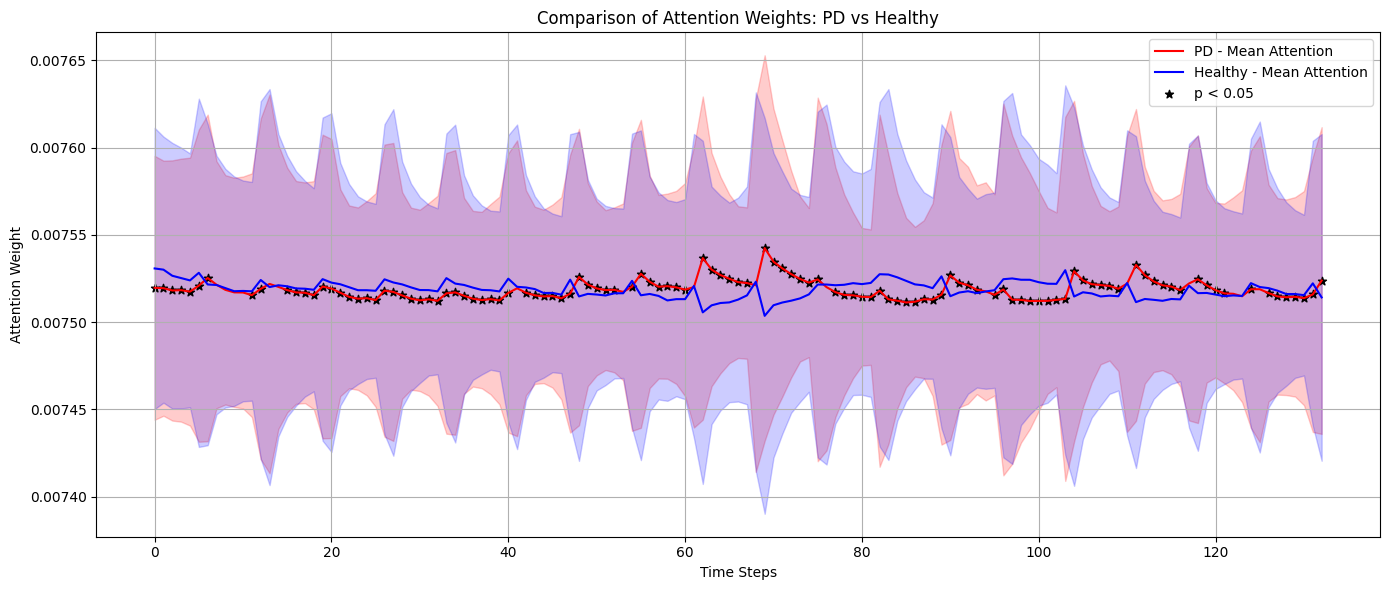

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# Step 1: Compute mean and std per time step
mean_attn_PD = np.mean(attention_weights_PD, axis=0)
std_attn_PD = np.std(attention_weights_PD, axis=0)

mean_attn_Healthy = np.mean(attention_weights_Healthy, axis=0)
std_attn_Healthy = np.std(attention_weights_Healthy, axis=0)

# Step 2: Statistical testing - T-test per time step
t_values, p_values = ttest_ind(attention_weights_PD, attention_weights_Healthy, axis=0)

# Step 3: Identify statistically significant time steps (p < 0.05)
significant_timesteps = np.where(p_values < 0.05)[0]

# Ensure 1D for plotting
mean_attn_PD = np.squeeze(mean_attn_PD)
std_attn_PD = np.squeeze(std_attn_PD)
mean_attn_Healthy = np.squeeze(mean_attn_Healthy)
std_attn_Healthy = np.squeeze(std_attn_Healthy)

# Plot
plt.figure(figsize=(14, 6))
plt.plot(mean_attn_PD, label='PD - Mean Attention', color='red')
plt.fill_between(range(len(mean_attn_PD)), mean_attn_PD - std_attn_PD, mean_attn_PD + std_attn_PD, color='red', alpha=0.2)

plt.plot(mean_attn_Healthy, label='Healthy - Mean Attention', color='blue')
plt.fill_between(range(len(mean_attn_Healthy)), mean_attn_Healthy - std_attn_Healthy, mean_attn_Healthy + std_attn_Healthy, color='blue', alpha=0.2)

# Significant time steps
plt.scatter(significant_timesteps, mean_attn_PD[significant_timesteps], color='black', marker='*', label='p < 0.05')

plt.title("Comparison of Attention Weights: PD vs Healthy")
plt.xlabel("Time Steps")
plt.ylabel("Attention Weight")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("t-test-Analysis.pdf", bbox_inches='tight')
plt.show()


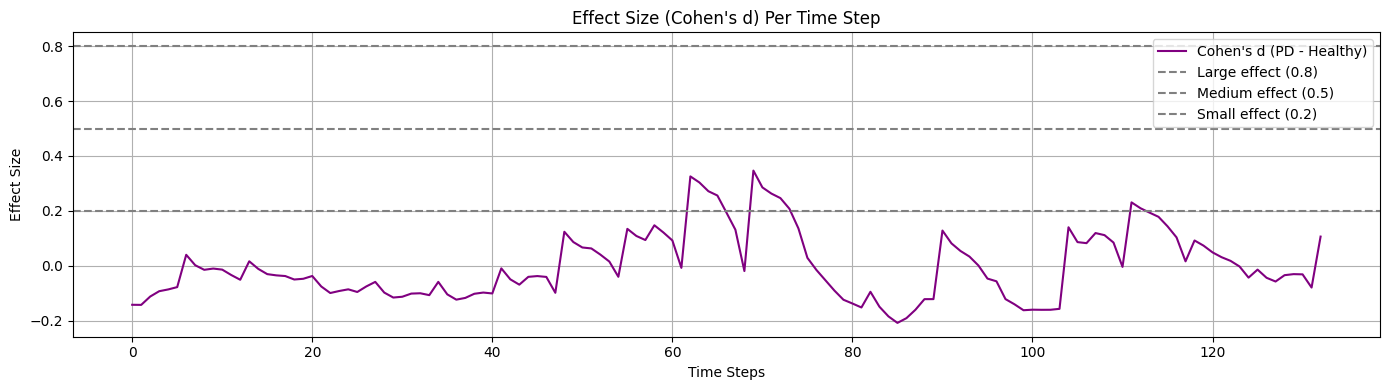

In [ ]:
def cohens_d(a, b):
    # Mean difference divided by pooled std dev
    pooled_std = np.sqrt((np.std(a, axis=0) ** 2 + np.std(b, axis=0) ** 2) / 2)
    return (np.mean(a, axis=0) - np.mean(b, axis=0)) / pooled_std

effect_sizes = cohens_d(attention_weights_PD, attention_weights_Healthy)

# Plot
plt.figure(figsize=(14, 4))
plt.plot(effect_sizes, label="Cohen's d (PD - Healthy)", color='purple')
plt.axhline(0.8, color='gray', linestyle='--', label='Large effect (0.8)')
plt.axhline(0.5, color='gray', linestyle='--', label='Medium effect (0.5)')
plt.axhline(0.2, color='gray', linestyle='--', label='Small effect (0.2)')
plt.title("Effect Size (Cohen's d) Per Time Step")
plt.xlabel("Time Steps")
plt.ylabel("Effect Size")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("cohens.pdf", bbox_inches='tight')
plt.show()
